<a href="https://colab.research.google.com/github/jocelynprince1/YCBS258/blob/master/H6_JPrince_File_1_NLP_with_Universal_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Homework #6 - Experimenting with NLP Tensorflow Hub modules (File 1 of 2)

* File 1: Notebook that creates the models and save the model on the GCP AI platform
* File 2: Notebook that is calling the services on GCP AI platform

#### Submitted by Jocelyn Prince (2019/12/_--------------___________)
---

# TODO !!!!!!!!!!!!!!!!!!!!!!!!

Check other Text Modules 
* Test with larger dataset

## Sentiment Analysis Project - Post to medium
#### NLP with the following Modules from Tensorflow Hub
* tf2-preview/nnlm-en-dim128 Module
* Universal Sentence Encoder


### Description
Deploying a model on Google's AI-Platform (also called ML Engine) and demonstrate the model returning a prediction.

1. Use the free tier of GCP: https://cloud.google.com/free/
2. Train a model using any dataset you want using keras, tensorflow, XGBoost or scikit-learn. You can do the training locally (or on colab)
3. Deploy the model on GCP's AI-Platform
4. Send a request to the AI-Platform and print out the prediction (File 2)

---------------

Details:
* Dataset for training: Sentiment140 (source: http://help.sentiment140.com/for-students/)

References:

https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/

https://arxiv.org/pdf/1802.05365.pdf

https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb#scrollTo=Eg62Pmz3o83v

Aurélien Géron's book
-----

In [0]:
#!pip install --upgrade tensorflow

In [0]:
#!pip install --upgrade scikit-learn

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [0]:
# This Notebook needs to be executed under Python ≥3.5 and TensorFlow >= 2.0
import sys
assert sys.version_info >= (3, 5)
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Minimum Requirement for Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.test.is_gpu_available():
    print("No GPU was detected. This code can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import time
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(20)
tf.random.set_seed(20)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER= "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
tf.__version__

'2.0.0'

In [0]:
tf.test.is_gpu_available()

True

In [0]:
# Tensorflow Imports
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

In [0]:
# The spacy module needs to be installed
!pip install spacy --user

In [0]:
# The english module needs to be downloaded if not already
!python3 -m spacy download en --user


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
# Import other common libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
import itertools
import re
import spacy

# Import Dataset: Sentiment140 Tweets


In [0]:
file = "/content/drive/My Drive/Colab Notebooks/Final_Project/data/training.1600000.processed.noemoticon.csv"

In [13]:
# Import data set

columns = ['polarity','id','date','query_string','twitter_user','tweet']
df = pd.read_csv(file,
                 header=None, 
                 names=columns, 
                 encoding='latin-1')
df.shape

(1600000, 6)

# Explore Data

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
polarity        1600000 non-null int64
id              1600000 non-null int64
date            1600000 non-null object
query_string    1600000 non-null object
twitter_user    1600000 non-null object
tweet           1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [15]:
df.describe()

,polarity,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [0]:
df.head()

,polarity,id,date,query_string,twitter_user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [0]:
df.tweet[0:10]

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
5                        @Kwesidei not the whole crew 
6                                          Need a hug 
7    @LOLTrish hey  long time no see! Yes.. Rains a...
8                 @Tatiana_K nope they didn't have it 
9                            @twittera que me muera ? 
Name: tweet, dtype: object

# Prepare X_train, y_train, X_test, y_test


In [0]:
train_set, test_set = train_test_split(df[["id", "tweet", "polarity"]], test_size=0.2, random_state=20)


In [0]:
X_train = train_set.drop("polarity", axis=1) # drop labels for training set
y_train = train_set["polarity"].copy()

In [0]:
X_test = test_set.drop("polarity", axis=1) # drop labels for testing datasset
y_test = test_set["polarity"].copy()

In [0]:
# take the first num records for development purposes
NUMTRAIN = 10000
NUMTEST = 2000
X_train = X_train[:NUMTRAIN]
X_test = X_test[:NUMTEST]
y_train = y_train[:NUMTRAIN]
y_test = y_test[:NUMTEST]

In [20]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("X_test: "+ str(X_test.shape))
print("y_train: "+ str(y_train.shape))
print("y_test: "+ str(y_test.shape))

X_train: (10000, 2)<class 'pandas.core.frame.DataFrame'>
X_test: (2000, 2)
y_train: (10000,)
y_test: (2000,)


In [21]:
print(type(y_train))
print(y_train.describe)

<class 'pandas.core.series.Series'>
<bound method NDFrame.describe of 519968     0
387493     0
208291     0
945933     4
1328534    4
          ..
923662     4
214655     0
1385214    4
713652     0
1521338    4
Name: polarity, Length: 10000, dtype: int64>


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d3ba28be0>]],
      dtype=object)

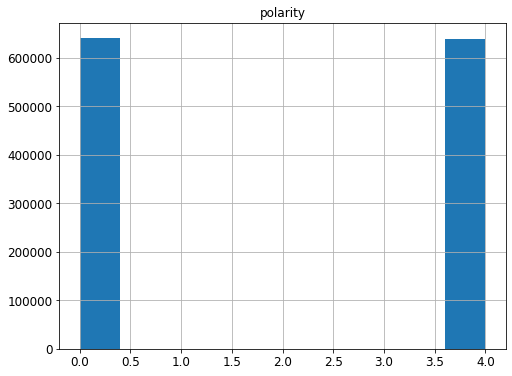

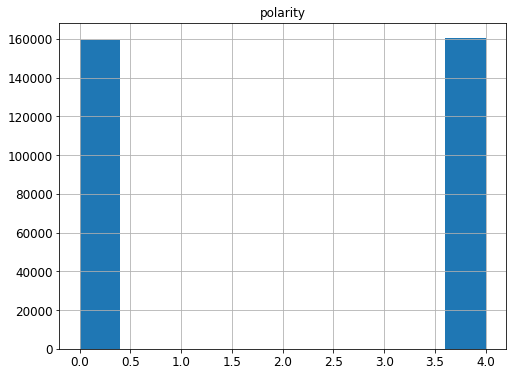

In [22]:
train_set.hist(["polarity"])
test_set.hist(["polarity"])

In [23]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)                     
y_train[:50]

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0])

In [0]:
y_train = keras.utils.to_categorical(y_train)

In [0]:
y_test = keras.utils.to_categorical(y_test)

In [26]:
y_train[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Data Preprocessing

### Function : Lemmatize (Normalize) Tweets

In [0]:
# import spaCy's language model
nlp = spacy.load('en', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [0]:
def text_processing(tweet):
    
    # remove https links
    clean_tweet = re.sub(r'http\S+', '', tweet)
    # remove punctuation marks
    punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
    clean_tweet = ''.join(ch for ch in clean_tweet if ch not in set(punctuation))
    # convert text to lowercase
    clean_tweet = clean_tweet.lower()
    # remove numbers
    clean_tweet = re.sub('\d', ' ', clean_tweet)
    # remove whitespaces
    clean_tweet = ' '.join(clean_tweet.split())
    return clean_tweet

In [0]:
X_train['clean_tweet'] = X_train['tweet'].apply(lambda x: text_processing(x))
X_test['clean_tweet'] = X_test['tweet'].apply(lambda x: text_processing(x))

In [30]:
X_train.sample(10)

,id,tweet,clean_tweet
253417,1983982010,@bunnirific online im storage is full again!!,bunnirific online im storage is full again
1021648,1882619189,@goange Why so Sick? Party too much last nite?,goange why so sick party too much last nite
756185,2288635230,I can't watch that show any more....,i can't watch that show any more....
1453955,2063279902,I am liking this wakeup twice a morning thing,i am liking this wakeup twice a morning thing
571373,2208806399,At the dr's office for an NST...,at the dr's office for an nst...
1131078,1975801751,heading to a fundraiser before the movie...sti...,heading to a fundraiser before the movie...sti...
932880,1771211724,I am thankful for the physio I'm going to toda...,i am thankful for the physio i'm going to toda...
415967,2061193534,@spahkleprincess NO! REALLY! When? and YAY!!!!...,spahkleprincess no really when and yay all my ...
140597,1881069045,doing dishes,doing dishes
72654,1694291069,"@Joelsk_ Haha, if there was an mtub at my work...","joelsk haha, if there was an mtub at my work i..."


In [31]:
%%time
X_train["clean_tweet"] = lemmatization(X_train["clean_tweet"])
X_test['clean_tweet'] = lemmatization(X_test['clean_tweet'])

CPU times: user 40.3 s, sys: 60.9 ms, total: 40.4 s
Wall time: 40.5 s


In [32]:
X_train.sample(5)

,id,tweet,clean_tweet
475152,2177519036,"Gah, why does she want me to go in for four ho...","gah , why do -PRON- want -PRON- to go in for f..."
1463417,2064128598,I'm mapping my feeds and cross-feeds in what c...,-PRON- be map -PRON- feed and crossfeed in wha...
562385,2205645615,@seratonation cant help but think he's upset a...,seratonation can not help but think -PRON- be ...
832168,1557554460,"@Saffiter Nope, in a money tin. I'm saving al...","saffiter nope , in a money tin . -PRON- be sav..."
1057924,1962817997,@thatBTCH yea do it or go honey blond like me,thatbtch yea do -PRON- or go honey blond like ...


In [33]:
X_test.sample(5)

,id,tweet,clean_tweet
182634,1967196903,"@JonathanRKnight Awww, poor Jon What a longgg...","jonathanrknight awww , poor jon what a longggg..."
1091603,1969900304,There should be a national twitter day where t...,there should be a national twitt day where -PR...
22242,1557444150,"I should be out in the sunshine, but I'm insid...","i should be out in the sunshine , but -PRON- b..."
876813,1684821211,i might go to ypsi,i may go to ypsi
218528,1976191369,@siltoso Can You See My PIc?? I Cant See it,siltoso can -PRON- see -PRON- pic i can not se...


In [0]:
X_train = X_train["clean_tweet"].values
X_test = X_test["clean_tweet"].values

In [35]:
print(X_train[0:10])

['iluvshinything no be not -PRON- . i be wear a pink tank top , black pant and big teal sunglass . close though ha'
 "-PRON- year old nephew just email -PRON- ask join -PRON- play mini golf , too bad i have breakfast amp meet amp greet in tyson 's so cute"
 'jscrinc -PRON- do not mess up'
 'jennny -PRON- be go to be jealous of -PRON- new iphone theme'
 'billharper yes , -PRON- be there be nothing like fresh fruit for lunch'
 'back from church , soooooo cold outside even though -PRON- look lovely and warm , instal manga studio now'
 'youngq yesterday be ice cream day .. awww'
 'i love jamie camille antonio happy year and month'
 'iremember ... gun n rose . omg -PRON- be the shit especially slash'
 'still rain , and there be a torrent of water from the roof right outside -PRON- bedroom window sound like an elephant have a pee']


# Create Model using tf.hub: nnlm-en-dim128

In [78]:
hub_layer1 = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", output_shape=[128], 
                           input_shape=[], 
                           dtype=tf.string
                          )
model = keras.Sequential()
model.add(hub_layer1)
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 124,646,882
Trainable params: 4,194
Non-trainable params: 124,642,688
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

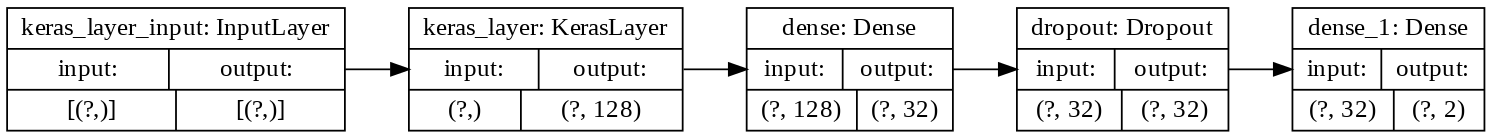

In [0]:
keras.utils.plot_model(model, 
                       #to_file='model.png',
                      show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

# Execute Model

In [80]:
%%time
hist = model.fit(X_train, 
                 y_train, 
                 epochs=70, 
                 batch_size=32, 
                 # callbacks=callbacks, 
                 # validation_split=0.1, 
                 verbose = 1)

Train on 10000 samples
Epoch 1/70
10000/10000 [==============================] - 2s 224us/sample - loss: 0.6568 - accuracy: 0.6009
Epoch 2/70
10000/10000 [==============================] - 2s 174us/sample - loss: 0.5972 - accuracy: 0.6869
Epoch 3/70
10000/10000 [==============================] - 2s 179us/sample - loss: 0.5789 - accuracy: 0.7014
Epoch 4/70
10000/10000 [==============================] - 2s 177us/sample - loss: 0.5673 - accuracy: 0.7117
Epoch 5/70
10000/10000 [==============================] - 2s 175us/sample - loss: 0.5604 - accuracy: 0.7133
Epoch 6/70
10000/10000 [==============================] - 2s 175us/sample - loss: 0.5581 - accuracy: 0.7157
Epoch 7/70
10000/10000 [==============================] - 2s 174us/sample - loss: 0.5509 - accuracy: 0.7196
Epoch 8/70
10000/10000 [==============================] - 2s 174us/sample - loss: 0.5475 - accuracy: 0.7218
Epoch 9/70
10000/10000 [==============================] - 2s 176us/sample - loss: 0.5447 - accuracy: 0.7275
Epoch

<function matplotlib.pyplot.show>

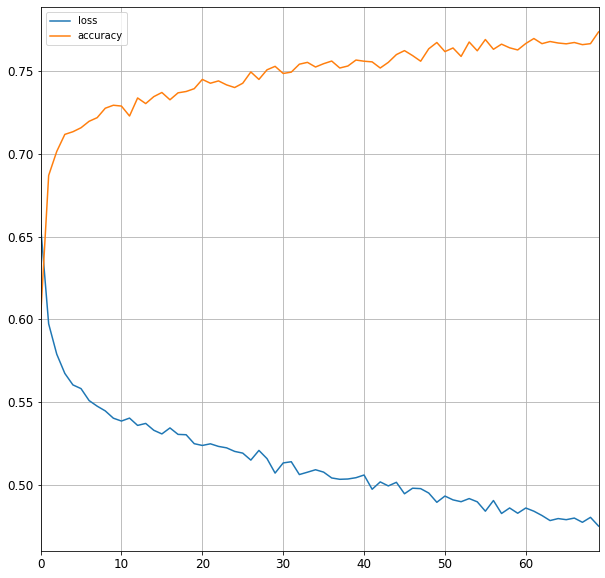

In [81]:
pd.DataFrame(hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

# Evaluate Model

In [82]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

2000/1 - 0s - loss: 0.7273 - accuracy: 0.7335
[0.552195641040802, 0.7335]


In [0]:
print(X_train[0:10])

In [84]:
predictions = model.predict(X_train[:10], batch_size=None, verbose=0)
print(predictions.round(0))

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [85]:
print(y_train[:10])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


# Confusion Matrix

In [0]:
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False,
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
# This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix") # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout() 
        plt.ylabel('True label') 
        plt.xlabel('Predicted label')

In [0]:
# np.argmax Returns the indices of the maximum values along an axis. 
y_test_rounded = np.argmax(y_test, axis=1)
y_train_rounded = np.argmax(y_train, axis=1)

In [0]:
y_pred = model.predict(X_train)
y_pred_rounded = np.argmax(y_pred, axis=1)

In [0]:
cmResults = confusion_matrix(y_train_rounded, y_pred_rounded)
accuracy = accuracy_score(y_train_rounded, y_pred_rounded)

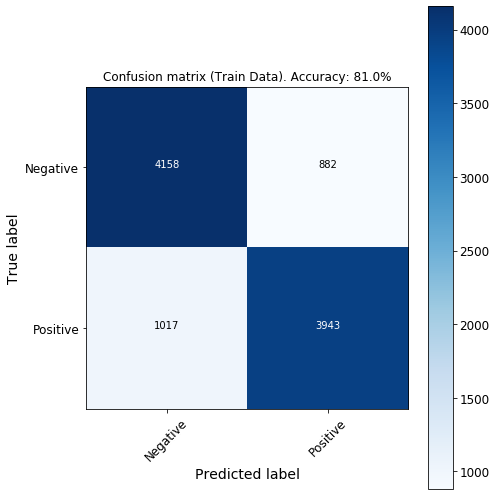

In [89]:
# Plot non-normalized confusion matrix 
class_names = ['Negative', 'Positive']
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, title='Confusion matrix (Train Data).' + " Accuracy: " + str(accuracy.round(3)*100) + "%" );

In [0]:
y_pred = model.predict(X_test)
y_pred_rounded = np.argmax(y_pred, axis=1)
cmResults = confusion_matrix(y_test_rounded, y_pred_rounded)
accuracy = accuracy_score(y_test_rounded, y_pred_rounded)

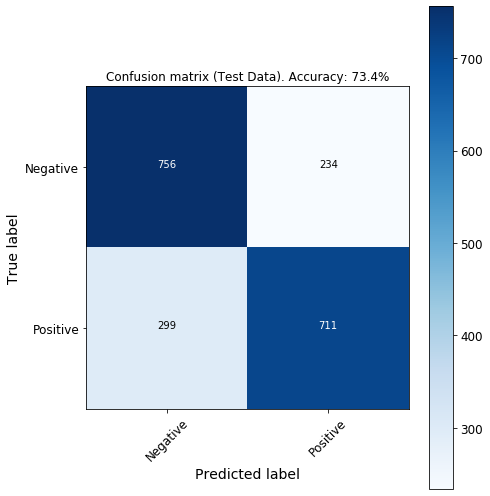

In [91]:
# Plot non-normalized confusion matrix 
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, title='Confusion matrix (Test Data).' + " Accuracy: " + str(accuracy.round(3)*100) + "%" );

# Test the Model with some sentences

In [0]:
# Create input tweets for testing the sentiment model 
tweets = {'tweet':['The seat was comfortable! and the bathroom was clean and food was great...',
                    'The flight attendant was nice ### but the temperature was cold ---',
                    'The movie was not funny at all and the drinks were very bad...',
                    'huh uhgyrt jjkoj . g red jgh kh kj k',
                    'I was told that the flight would be bad but actually it was very good, thanks US Ailine',
                    'I was told that the flight would be good but actually it was very bad, thanks US Ailine',
                    'It would be nice if the weather was better in Montreal *&&%&*&##!1',
                    'The Montreal hockey team is working very hard to be in the playoffs'
                   ],
          'sentiments':['positive',
                       'positive',
                       'negative',
                       'negative',
                       'positive',
                       'negative',
                       'negative',
                       'positive'
                      ]
         } 
  
# Create DataFrame 
df_test = pd.DataFrame(tweets)

In [0]:
df_test['clean_tweet'] = df_test['tweet'].apply(lambda x: text_processing(x))

In [0]:
df_test["clean_tweet"] = lemmatization(df_test["clean_tweet"])

In [95]:
df_test

,tweet,sentiments,clean_tweet
0,The seat was comfortable! and the bathroom was...,positive,the seat be comfortable and the bathroom be cl...
1,The flight attendant was nice ### but the temp...,positive,the flight attendant be nice but the temperatu...
2,The movie was not funny at all and the drinks ...,negative,the movie be not funny at all and the drink be...
3,huh uhgyrt jjkoj . g red jgh kh kj k,negative,huh uhgyrt jjkoj . g red jgh kh kj k
4,I was told that the flight would be bad but ac...,positive,i be tell that the flight would be bad but act...
5,I was told that the flight would be good but a...,negative,i be tell that the flight would be good but ac...
6,It would be nice if the weather was better in ...,negative,-PRON- would be nice if the weather be well in...
7,The Montreal hockey team is working very hard ...,positive,the montreal hockey team be work very hard to ...


In [96]:
sentiments = df_test["sentiments"].copy()
label_encoder = LabelEncoder()
sentiments = label_encoder.fit_transform(sentiments)
sentiments = keras.utils.to_categorical(sentiments)
sentiments[:6]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [0]:
X_input = df_test["clean_tweet"].values

In [98]:
print(model.predict(X_input).round(0))

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [99]:
print(sentiments)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


# Universal Sentence Encoder



## Create Model

In [102]:
hub_layer2 = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                           output_shape=[512], 
                           input_shape=[], 
                           dtype=tf.string
                          )
model = keras.Sequential()
model.add(hub_layer2)
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_8 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 256,814,306
Trainable params: 16,482
Non-trainable params: 256,797,824
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

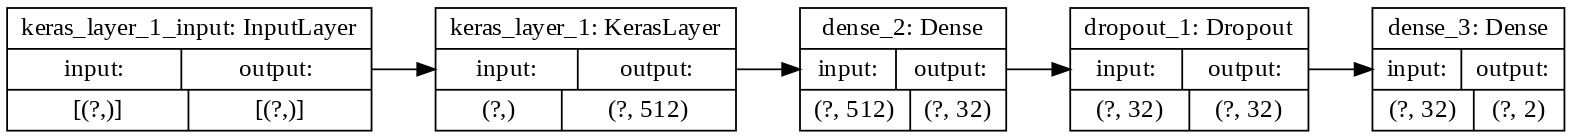

In [0]:
keras.utils.plot_model(model, 
                       #to_file='model.png',
                       show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

## Execute Model

In [104]:
%%time
hist = model.fit(X_train, 
                 y_train, 
                 epochs=20, 
                 batch_size=32, 
                 # callbacks=callbacks, 
                 # validation_split=0.1, 
                 verbose = 1)

Train on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 7s 658us/sample - loss: 0.5860 - accuracy: 0.6965
Epoch 2/20
10000/10000 [==============================] - 5s 501us/sample - loss: 0.5208 - accuracy: 0.7464
Epoch 3/20
10000/10000 [==============================] - 5s 503us/sample - loss: 0.5089 - accuracy: 0.7517
Epoch 4/20
10000/10000 [==============================] - 5s 510us/sample - loss: 0.5015 - accuracy: 0.7594
Epoch 5/20
10000/10000 [==============================] - 5s 500us/sample - loss: 0.4960 - accuracy: 0.7603
Epoch 6/20
10000/10000 [==============================] - 5s 500us/sample - loss: 0.4882 - accuracy: 0.7593
Epoch 7/20
10000/10000 [==============================] - 5s 496us/sample - loss: 0.4864 - accuracy: 0.7619
Epoch 8/20
10000/10000 [==============================] - 5s 497us/sample - loss: 0.4792 - accuracy: 0.7695
Epoch 9/20
10000/10000 [==============================] - 5s 499us/sample - loss: 0.4777 - accuracy: 0.7683
Epoch

<function matplotlib.pyplot.show>

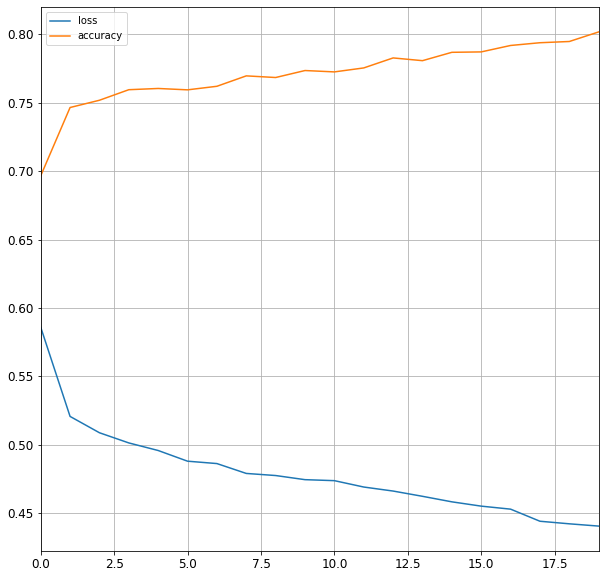

In [105]:
pd.DataFrame(hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

# Evaluate Model Universal Sentence Encoder

In [106]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

2000/1 - 1s - loss: 0.5722 - accuracy: 0.7715
[0.48606407594680784, 0.7715]


In [107]:
print(X_train[0:10])

['iluvshinything no be not -PRON- . i be wear a pink tank top , black pant and big teal sunglass . close though ha'
 "-PRON- year old nephew just email -PRON- ask join -PRON- play mini golf , too bad i have breakfast amp meet amp greet in tyson 's so cute"
 'jscrinc -PRON- do not mess up'
 'jennny -PRON- be go to be jealous of -PRON- new iphone theme'
 'billharper yes , -PRON- be there be nothing like fresh fruit for lunch'
 'back from church , soooooo cold outside even though -PRON- look lovely and warm , instal manga studio now'
 'youngq yesterday be ice cream day .. awww'
 'i love jamie camille antonio happy year and month'
 'iremember ... gun n rose . omg -PRON- be the shit especially slash'
 'still rain , and there be a torrent of water from the roof right outside -PRON- bedroom window sound like an elephant have a pee']


In [109]:
predictions = model.predict(X_train[:10], batch_size=None, verbose=0)
print(predictions.round(0))

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [110]:
y_train[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Confusion Matrix

In [0]:
# np.argmax Returns the indices of the maximum values along an axis. 
y_test_rounded = np.argmax(y_test, axis=1)
y_train_rounded = np.argmax(y_train, axis=1)

In [0]:
y_pred = model.predict(X_train)
y_pred_rounded = np.argmax(y_pred, axis=1)

In [0]:
cmResults = confusion_matrix(y_train_rounded, y_pred_rounded)
accuracy = accuracy_score(y_train_rounded, y_pred_rounded)

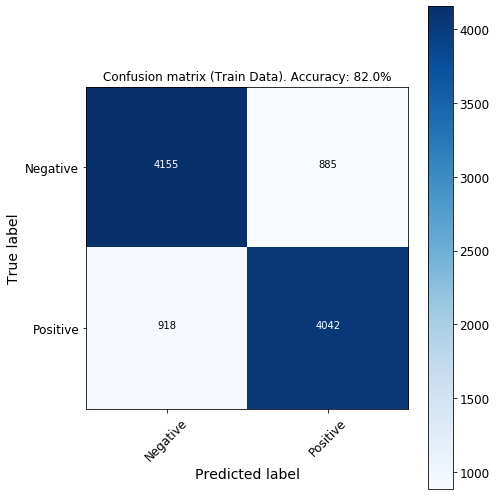

In [114]:
# Plot non-normalized confusion matrix 
class_names = ['Negative', 'Positive']
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, title='Confusion matrix (Train Data).' + " Accuracy: " + str(accuracy.round(3)*100) + "%" );

In [0]:
y_pred = model.predict(X_test)
y_pred_rounded = np.argmax(y_pred, axis=1)
cmResults = confusion_matrix(y_test_rounded, y_pred_rounded)
accuracy = accuracy_score(y_test_rounded, y_pred_rounded)

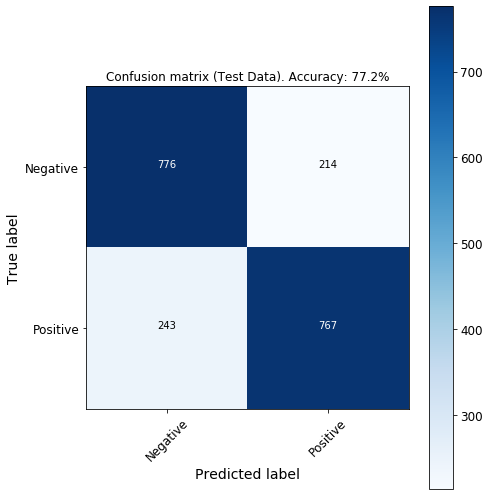

In [116]:
# Plot non-normalized confusion matrix 
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, title='Confusion matrix (Test Data).' + " Accuracy: " + str(accuracy.round(3)*100) + "%" );

# Test the Model with some sentences

In [118]:
print(model.predict(X_input).round(0))

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [119]:
print(sentiments)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


# Save Keras Model

In [0]:
# save model and architecture to single file
model_version = "0002"
model_name = "JP_sentiment_analysis_service"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)
print("Saved model to disk")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: JP_sentiment_analysis_service/0002/assets


INFO:tensorflow:Assets written to: JP_sentiment_analysis_service/0002/assets


Saved model to disk


In [0]:
!saved_model_cli show --dir {model_path}

2019-12-09 21:12:34.251754: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
The given SavedModel contains the following tag-sets:
serve


In [0]:
!saved_model_cli show --dir {model_path} --tag_set serve

2019-12-09 21:12:39.705170: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


In [0]:
!saved_model_cli show --dir {model_path} --tag_set serve \
                      --signature_def serving_default

2019-12-09 21:12:48.232252: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall_2:0
Method name is: tensorflow/serving/predict


In [0]:
!saved_model_cli show --dir {model_path} --all

2019-12-09 21:12:53.370525: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['keras_layer_input'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_keras_layer_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: StatefulPartitionedCall_2:0
  Method name is: t

-------- 
### Comments
A savedModel contains one or more metagraphs.

A metagraph contains:
* Input names
* Output names
* Types
* Shapes

Tags like "train", "gpu and the default: "serve"
Below we test the savedModel with a numpy input. This is just for local testing.

---------





In [0]:
X_new = X_test[0:3]
np.save("my_sentiment_analysis_tests.npy", X_new)

In [0]:
input_name = model.input_names[0]
input_name

'keras_layer_input'

!saved_model_cli run --dir {model_path} --tag_set serve \
                     --signature_def serving_default    \
                     --inputs {input_name}=my_sentiment_analysis_tests.npy

# Copy Model to Google Storage (Bucket)

In [0]:
import sys

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''

env: GOOGLE_APPLICATION_CREDENTIALS=''


In [0]:
PROJECT_ID = "utopian-rush-255612" #@param {type:"string"}

# This must absolutely be a GLOBALLY UNIQUE name
BUCKET_NAME = "utopian-rush-255612-bucket_ml" #@param {type:"string"}
REGION = "us-east1" #@param {type:"string"}

! gcloud config set project $PROJECT_ID
! echo $PROJECT_ID

OSError: [Errno 12] Cannot allocate memory

In [0]:
# Create Bucket

# ! gsutil mb -p $PROJECT_ID -l $REGION gs://$BUCKET_NAME
# Display what is in the bucket
!gsutil ls -al gs://$BUCKET_NAME

OSError: [Errno 12] Cannot allocate memory

In [0]:
JOB_DIR = 'gs://' + BUCKET_NAME + '/my_sentiment_analysis_model'

In [0]:
# Export the model to a local SavedModel directory 
# export_path = tf.contrib.saved_model.save_keras_model(model, 'keras_export')
# print("Model exported to: ", export_path)

# Export the model to a SavedModel directory in Cloud Storage
export_path = tf.saved_model.save(model, JOB_DIR + '/0002')
# print("Model exported to: ", export_path)

# Create the Model in the AI Platform

In [0]:
MODEL_NAME = "my_sentiment_analysis"

! gcloud ai-platform models create $MODEL_NAME --regions $REGION

ERROR: (gcloud.ai-platform.models.create) Resource in project [utopian-rush-255612] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


# Create the Version of the Model in AI Platform
## Note: I created the version directly in the GUI

MODEL_VERSION = "v1"

# Get a list of directories in the `keras_export` parent directory
KERAS_EXPORT_DIRS = ! gsutil ls $JOB_DIR/0001/

# Pick the directory with the latest timestamp, in case you've trained
# multiple times
SAVED_MODEL_PATH = KERAS_EXPORT_DIRS[-1]

# Create model version based on that SavedModel directory
! gcloud ai-platform versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --runtime-version 1.13 \
  --python-version 3.5 \
  --framework tensorflow \
  --origin $SAVED_MODEL_PATH

# Create Service Account to Access the Service in a Secure Fashion

### I created the service account directly in the GUI

### I downloaded the secure key (json file) in my jupyter space to be used later by another notebook
